## Wykrywanie anomalii w rzeczywistych zbiorach 

    Zadanie wyjaśnimy na podstawie zbioru danych SMTP - zawierającego anomalie (ataki) SMTP.
    
    Ten zbiór i inne rzeczywiste zbiory danych do wykorzystania w I części laboratorium pobieramy z: 
    http://odds.cs.stonybrook.edu/
    

### SMTP dataset

https://web.archive.org/web/20240621223546/http://odds.cs.stonybrook.edu/smtp-kddcup99-dataset/

Smtp (KDDCUP99)	\
points:      95156	\
dimenstions: 3	\
outliers:     30 (0.03%)

Zbiór zawiera wybrane (zagregowane) cechy połączeń TCP, spośród których 30 (oznaczone jako outliers) to próby ataku, pozostałe - normalny ruch (inliers).

Zadanie polega na zbadaniu skuteczności różnych metod wykrywania anomalii do detekcji tych ataków.  


In [ ]:
#%pip install h5py

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ---------------------------------------- 3.0/3.0 MB 24.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import h5py
f = h5py.File('./data/smtp.mat','r')
print(f.keys())


<KeysViewHDF5 ['X', 'y']>


In [3]:
X = np.array(f.get('X')).T
y = np.array(f.get('y')).ravel().astype(int)

In [4]:
# X zawiera obserwacje (wiersze) - cechy połączeń
# y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)
print(X)
print(X.shape)
print(y)
print(y.shape)  # 0 - inlier, 1 - outlier

print(np.asarray(np.unique(y, return_counts=True)))

[[ 0.09531018  7.09597607  5.79636166]
 [ 0.09531018  7.42601321  5.80844275]
 [-2.30258509  6.88663378  5.79939564]
 ...
 [-2.30258509  6.73471056  5.79939564]
 [ 0.09531018  6.91879413  5.80844275]
 [ 0.09531018  6.60272357  5.80242044]]
(95156, 3)
[0 0 0 ... 0 0 0]
(95156,)
[[    0     1]
 [95126    30]]


### LOF 

In [5]:
from sklearn.neighbors import LocalOutlierFactor

# model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination='auto') 
model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.001) 

y_pred = model.fit_predict(X)  # 1 - inlier, -1 - outlier

In [6]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [7]:
print(np.array(np.unique(y, return_counts=True)))
print(np.array(np.unique(y_pred, return_counts=True)))

[[    0     1]
 [95126    30]]
[[    0     1]
 [95060    96]]


In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[95030,    96],
       [   30,     0]])

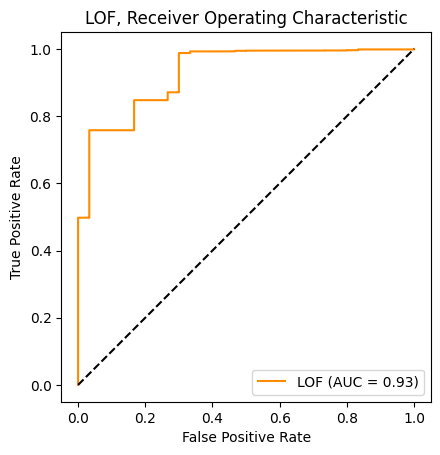

In [9]:
### plot ROC curve

import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(X)
anomaly_score = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    anomaly_score,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


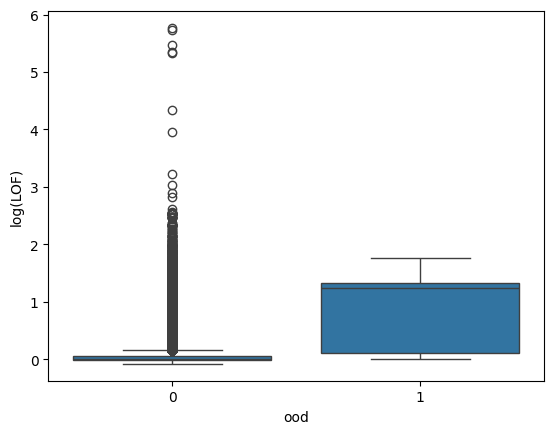

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
     
of = np.log(-anomaly_score)

data = pd.DataFrame({'lof': of,'ood': y})

sns.boxplot(x='ood', y='lof', data=data).set(
    ylabel='log(LOF)')

plt.show()
